A notebook where we synthesize regression models, when the true systems have an m function which is a Quadratic surface.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy
import math

import matplotlib.pyplot as plt
import numpy as np
import torch

from janelia_core.ml.extra_torch_modules import DenseLNLNet
from janelia_core.ml.extra_torch_modules import QuadSurf
from janelia_core.ml.utils import list_torch_devices

from probabilistic_model_synthesis.gaussian_nonlinear_regression import compare_weight_prior_dists
from probabilistic_model_synthesis.gaussian_nonlinear_regression import align_low_d_spaces
from probabilistic_model_synthesis.gaussian_nonlinear_regression import fit_with_hypercube_priors
from probabilistic_model_synthesis.gaussian_nonlinear_regression import Fitter
from probabilistic_model_synthesis.gaussian_nonlinear_regression import generate_hypercube_prior_collection
from probabilistic_model_synthesis.gaussian_nonlinear_regression import GNLRMdl
from probabilistic_model_synthesis.simulation import generate_sum_of_bump_fcns_dist
from probabilistic_model_synthesis.simulation import sample_proj_data_from_interval
from probabilistic_model_synthesis.visualization import assign_colors_to_pts
from probabilistic_model_synthesis.visualization import plot_three_dim_pts

In [3]:
%matplotlib notebook

## Parameters go here

In [12]:
# Range of the number of input variables we observe from each individual - the actual number of variables we 
# observe from an individual will be pulled uniformly from this range (inclusive)
n_input_var_range = [5000, 5100]

# Range of the number of samples we observe from each individual - the actual number we observe from each individual
# will be unformly from this range (inclusive)
n_smps_range = [12000, 15000]

# ===============================================================================================
# Parameters for the true priors 

true_hc_params = {'n_divisions_per_dim': [10, 10], 
                  'dim_ranges': np.asarray([[-.1, 1.1],
                                       [-.1, 1.1]]),
                   'n_div_per_hc_side_per_dim': [1, 1]}

# The full options for setting up the prior on weights
true_w_prior_opts = {'mn_hc_params': true_hc_params, 'std_hc_params': true_hc_params, 
                     'min_std': .000001, 'mn_init': 0.0, 'std_init': .3}

# Options for the prior distributions on the scales, biases and psi
true_s_in_prior_opts = {'mn_mn': 1.0/np.sqrt(n_input_var_range[0]), 'mn_std': .00000001, 
                     'std_iv': .00001, 'std_lb': .0000001}

true_s_out_prior_opts = {'mn_mn': 1.0, 'mn_std': .00000001, 
                     'std_iv': .00001, 'std_lb': .0000001}

true_b_prior_opts = {'mn_mn': 0.0, 'mn_std': .00000001, 'std_iv': .001}
true_psi_prior_opts = {'conc_iv': 10.0, 'rate_iv': 1000.0, 'rate_ub': 10000.0}

# Specify the number of intermediate variables and number of variables we predict
p = 1
d_pred = 1

# ===============================================================================================
# Parameters for the fit models

# The full options for setting up the prior on weights
fit_hc_params = {'n_divisions_per_dim': [20, 20], 
                 'dim_ranges': np.asarray([[-.1, 1.1],
                                       [-.1, 1.1]]),
                 'n_div_per_hc_side_per_dim': [1, 1]}

# The full options for setting up the prior on weights
fit_w_prior_opts = {'mn_hc_params': fit_hc_params, 'std_hc_params': fit_hc_params, 
                     'min_std': .000001, 'mn_init': 0.0, 'std_init': .3}

# Options for the prior distributions on the scales, biases and psi
fit_s_in_prior_opts = true_s_in_prior_opts
fit_s_out_prior_opts = true_s_out_prior_opts
fit_b_prior_opts = true_b_prior_opts
fit_psi_prior_opts = true_psi_prior_opts

# Options for posterior distribtions 
s_in_post_opts = {'mn_mn': 1.0/np.sqrt(n_input_var_range[0]), 'mn_std': .000001, 
               'std_iv': .00001, 'std_lb': .0000001}
s_out_post_opts = {'mn_mn': 1.0, 'mn_std': .000001, 
               'std_iv': .00001, 'std_lb': .0000001}

b_post_opts = {'mn_mn': 0.0, 'mn_std': .01}
psi_post_opts = {'conc_iv': 10.0, 'rate_iv': 1.0, 'rate_ub': 100000.0}

# Options for the densenet which makes up the shared-m module
dense_net_opts = {'n_layers': 10, 'growth_rate': 5, 'bias': True}

# ======================================================================================================
# Parameters for fitting - should be entered as lists, each entry corresponding to one round of fitting
sp_fit_opts = [{'n_epochs': 100, 'milestones': None, 'update_int': 100, 'init_lr': .1}]
ip_fit_opts = [{'n_epochs': 5000, 'milestones': [500], 'update_int': 100, 'init_lr': .1}]

## Create true distributions that govern how systems under study are generated

In [13]:
true_priors = generate_hypercube_prior_collection(p=p, d_pred=d_pred, 
                                                  w_prior_opts=true_w_prior_opts, 
                                                  s_in_prior_opts=true_s_in_prior_opts, 
                                                  b_in_prior_opts=true_b_prior_opts, 
                                                  s_out_prior_opts=true_s_out_prior_opts,
                                                  b_out_prior_opts=true_b_prior_opts, 
                                                  psi_prior_opts=true_psi_prior_opts)

# We replace the prior over weights 
true_priors.w_prior = generate_sum_of_bump_fcns_dist(n_bump_fcns=50, d_in=2, p=1, 
                                                     mn_m_std=1.0, std_m_std=.1, bump_w=.2)

#for d in range(2):
#    true_priors.w_prior.dists[d].mn_f.b_m.data[:] = torch.randn(true_priors.w_prior.dists[d].mn_f.b_m.data.shape)
#    true_priors.w_prior.dists[d].std_f[0].b_m.data[:] -= 1.0*torch.rand(true_priors.w_prior.dists[d].std_f[0].b_m.shape)
#    true_priors.w_prior.dists[d].std_f[0].b_m.data[torch.arange(0, 100, 3, dtype=torch.long)] = 1.0

## Define the true non-linear function relating projections of input variables to the mean of output variables

In [14]:
class Quad(torch.nn.Module):
    
    def forward(self, x):
        #return .1*x + 1.0*(x**2)
        return x + np.sin(3*x) 

In [15]:
m_true = Quad()

## Generate data

### Generate properties

In [16]:
n_individuals = 4
ind_n_vars = np.random.randint(n_input_var_range[0], n_input_var_range[1]+1, n_individuals)
ind_props = [torch.rand(size=[n_vars,2]) for n_vars in ind_n_vars]

### Generate true models for each individual

In [17]:
with torch.no_grad():
    ind_true_mdls = [GNLRMdl(m=m_true, 
                     w=true_priors.w_prior.form_standard_sample(true_priors.w_prior.sample(props)),
                     s_in=true_priors.s_in_prior.form_standard_sample(true_priors.s_in_prior.sample(props)).squeeze(axis=1),
                     b_in=true_priors.b_in_prior.form_standard_sample(true_priors.b_in_prior.sample(props)).squeeze(axis=1),
                     s_out=true_priors.s_out_prior.form_standard_sample(true_priors.s_out_prior.sample(props)).squeeze(axis=1),
                     b_out=true_priors.b_out_prior.form_standard_sample(true_priors.b_out_prior.sample(props)).squeeze(axis=1),
                     psi=true_priors.psi_prior.form_standard_sample(true_priors.psi_prior.sample(props)).squeeze(axis=1))
                     for props in ind_props]
    
    if d_pred > 1:
        for mdl in ind_true_mdls:
            mdl.s_out.data = mdl.s_out.data.squeeze()
            mdl.b_out.data = mdl.b_out.data.squeeze()
            mdl.psi.data = mdl.psi.data.squeeze()
                             

### Generate observations from true models

In [18]:
ind_n_smps = np.random.randint(n_smps_range[0], n_smps_range[1]+1, n_individuals)
ind_data = [None]*n_individuals

intervals = 1.96*np.sqrt(n_input_var_range[0])*np.linspace(-1, 1, n_individuals+1)

for i in range(n_individuals):
    x_i = torch.tensor(sample_proj_data_from_interval(n_smps=ind_n_smps[i], 
                                                      w=ind_true_mdls[i].w.detach().numpy(), 
                                                      interval=[intervals[i], intervals[i+1]]),
                       dtype=torch.float)
    with torch.no_grad():
        y_i = ind_true_mdls[i].sample(x=x_i)
    ind_data[i] = (x_i, y_i)
    
    print('Done generating data for individual ' + str(i) + '.')
    

Done generating data for individual 0.
Done generating data for individual 1.
Done generating data for individual 2.
Done generating data for individual 3.


## Synthesize models (fit models to the data together)

In [19]:
fit_rs = fit_with_hypercube_priors(data=ind_data, props=ind_props, p=1, 
                                   w_prior_opts=fit_w_prior_opts, 
                                   s_in_prior_opts=fit_s_in_prior_opts,
                                   b_in_prior_opts=fit_b_prior_opts,
                                   s_out_prior_opts=fit_s_out_prior_opts,
                                   b_out_prior_opts=fit_b_prior_opts,
                                   psi_prior_opts=fit_psi_prior_opts,
                                   s_in_post_opts=s_in_post_opts,
                                   b_in_post_opts=b_post_opts,
                                   s_out_post_opts=s_out_post_opts,
                                   b_out_post_opts=b_post_opts,
                                   psi_post_opts=psi_post_opts,
                                   dense_net_opts=dense_net_opts, 
                                   sp_fit_opts=sp_fit_opts, 
                                   ip_fit_opts=ip_fit_opts)
                        

Found 1 GPUs
Beginning SP fitting.

=========== EPOCH 0 COMPLETE ===========
Obj: 2.03e+08
----------------------------------------
NELL: 4.81e+04, 4.38e+04, 3.26e+04, 3.60e+04
W KL: 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00
S_in KL: 2.53e+07, 2.53e+07, 2.53e+07, 2.53e+07
B_in KL: 2.54e+03, 1.67e+03, 1.54e+03, 2.08e+03
S_out KL: 2.53e+07, 2.53e+07, 2.53e+07, 2.53e+07
B_out KL: 2.10e+03, 2.49e+03, 1.58e+03, 1.88e+03
Psi KL: 7.78e+03, 7.78e+03, 7.78e+03, 7.78e+03
----------------------------------------
LR: 0.1
Elapsed time (secs): 0.1113128662109375
----------------------------------------
CPU cur memory used (GB): 5.68e+00
GPU_0 cur memory used (GB): 2.16e+00, max memory used (GB): 2.16e+00
Beginning IP fitting.

=========== EPOCH 0 COMPLETE ===========
Obj: 2.04e+08
----------------------------------------
NELL: 3.62e+04, 2.89e+04, 9.86e+04, 9.81e+05
W KL: 7.27e+04, 7.57e+04, 7.46e+04, 7.33e+04
S_in KL: 2.53e+07, 2.53e+07, 2.53e+07, 2.53e+07
B_in KL: 1.54e+03, 1.29e+03, 1.58e+03, 1.82e+0


=========== EPOCH 1200 COMPLETE ===========
Obj: -1.17e+03
----------------------------------------
NELL: -8.61e+03, -9.78e+03, -7.48e+03, -5.83e+03
W KL: 6.13e+03, 8.70e+03, 7.78e+03, 6.44e+03
S_in KL: 7.65e+00, 5.76e+00, 2.72e+01, 1.13e+03
B_in KL: 1.16e+01, 5.81e+01, 4.11e+01, 4.24e+01
S_out KL: 1.04e-03, 1.00e-03, 1.04e-02, 4.32e-02
B_out KL: 8.51e+00, 4.26e+01, 7.39e+01, 1.68e+01
Psi KL: 1.94e+00, 1.82e+00, 1.42e+00, 6.16e-01
----------------------------------------
LR: 0.010000000000000002
Elapsed time (secs): 151.17197108268738
----------------------------------------
CPU cur memory used (GB): 6.68e+00
GPU_0 cur memory used (GB): 2.16e+00, max memory used (GB): 2.16e+00

=========== EPOCH 1300 COMPLETE ===========
Obj: -5.29e+03
----------------------------------------
NELL: -8.73e+03, -9.80e+03, -7.39e+03, -8.84e+03
W KL: 6.13e+03, 8.70e+03, 7.83e+03, 6.18e+03
S_in KL: 9.03e+00, 1.17e+01, 9.66e+00, 3.17e+02
B_in KL: 1.37e+01, 6.59e+01, 5.37e+01, 2.78e+01
S_out KL: 1.82e-03, 1.


=========== EPOCH 2400 COMPLETE ===========
Obj: -5.97e+03
----------------------------------------
NELL: -7.41e+03, -9.93e+03, -7.49e+03, -9.58e+03
W KL: 5.36e+03, 8.73e+03, 7.86e+03, 5.76e+03
S_in KL: 4.26e+02, 2.79e+01, 8.26e-01, 4.56e+01
B_in KL: 1.12e+01, 3.72e+01, 5.44e+01, 1.67e+01
S_out KL: 1.12e-01, 3.49e-03, 1.52e-02, 3.06e-02
B_out KL: 1.09e+01, 4.36e+01, 4.89e+01, 1.44e+01
Psi KL: 6.00e-01, 7.60e-01, 2.91e-01, 2.32e-01
----------------------------------------
LR: 0.010000000000000002
Elapsed time (secs): 308.5967478752136
----------------------------------------
CPU cur memory used (GB): 6.68e+00
GPU_0 cur memory used (GB): 2.16e+00, max memory used (GB): 2.16e+00

=========== EPOCH 2500 COMPLETE ===========
Obj: -4.32e+03
----------------------------------------
NELL: -6.92e+03, -9.80e+03, -7.50e+03, -8.97e+03
W KL: 5.40e+03, 8.73e+03, 7.85e+03, 5.71e+03
S_in KL: 5.57e+02, 5.46e+00, 1.38e+01, 3.62e+02
B_in KL: 1.10e+01, 5.02e+01, 6.33e+01, 1.08e+01
S_out KL: 1.24e-02, 2.1


=========== EPOCH 3600 COMPLETE ===========
Obj: -4.18e+03
----------------------------------------
NELL: -7.79e+03, -9.47e+03, -7.20e+03, -9.90e+03
W KL: 5.32e+03, 8.64e+03, 7.82e+03, 5.89e+03
S_in KL: 1.05e+01, 9.35e+02, 9.95e+02, 2.69e+01
B_in KL: 8.76e+00, 4.38e+01, 4.33e+01, 6.81e+00
S_out KL: 8.72e+01, 2.70e+00, 9.85e+01, 1.27e+02
B_out KL: 1.37e+01, 4.05e+01, 3.92e+01, 1.03e+01
Psi KL: 5.42e-01, 6.16e-01, 7.62e-01, 4.27e-01
----------------------------------------
LR: 0.010000000000000002
Elapsed time (secs): 465.6685483455658
----------------------------------------
CPU cur memory used (GB): 6.68e+00
GPU_0 cur memory used (GB): 2.16e+00, max memory used (GB): 2.16e+00

=========== EPOCH 3700 COMPLETE ===========
Obj: -3.37e+03
----------------------------------------
NELL: -7.29e+03, -9.72e+03, -7.59e+03, -7.85e+03
W KL: 5.23e+03, 8.68e+03, 7.85e+03, 5.79e+03
S_in KL: 2.43e+02, 4.18e+00, 9.25e+01, 9.84e+02
B_in KL: 9.38e+00, 4.18e+01, 3.49e+01, 1.40e+01
S_out KL: 3.06e+00, 4.2


=========== EPOCH 4800 COMPLETE ===========
Obj: -1.78e+03
----------------------------------------
NELL: -7.47e+03, -9.63e+03, -7.45e+03, -7.88e+03
W KL: 5.26e+03, 8.72e+03, 7.84e+03, 5.82e+03
S_in KL: 2.81e+02, 1.18e+03, 1.30e+02, 1.08e+03
B_in KL: 1.42e+01, 4.19e+01, 1.83e+01, 6.19e+01
S_out KL: 8.72e+00, 6.04e+01, 1.12e+01, 9.11e+00
B_out KL: 1.39e+01, 6.00e+01, 3.10e+01, 1.69e+01
Psi KL: 8.09e-01, 2.02e+00, 7.94e-01, 2.25e+00
----------------------------------------
LR: 0.010000000000000002
Elapsed time (secs): 626.4822976589203
----------------------------------------
CPU cur memory used (GB): 6.68e+00
GPU_0 cur memory used (GB): 2.16e+00, max memory used (GB): 2.16e+00

=========== EPOCH 4900 COMPLETE ===========
Obj: -4.02e+02
----------------------------------------
NELL: -7.60e+03, -8.66e+03, -7.61e+03, -1.01e+04
W KL: 5.34e+03, 8.74e+03, 7.86e+03, 5.91e+03
S_in KL: 4.72e+01, 3.73e+03, 1.49e+01, 2.09e+01
B_in KL: 1.57e+01, 4.08e+01, 3.95e+01, 1.28e+01
S_out KL: 1.36e+01, 2.6

## Look at model fits

In [20]:
exam_ind = 3
exam_type = 'ip'

In [21]:
if exam_type == 'sp':
    exam_priors = fit_rs['sp']['priors']
    exam_posts = [coll.posteriors for coll in fit_rs['sp']['vi_collections']]
    exam_vi_collections = fit_rs['sp']['vi_collections']
    exam_mdls = [coll.mdl for coll in fit_rs['sp']['vi_collections']]
    exam_logs = fit_rs['sp']['logs']
else:
    exam_priors = fit_rs['ip']['priors']
    exam_posts = [coll.posteriors for coll in fit_rs['ip']['vi_collections']]
    exam_vi_collections = fit_rs['ip']['vi_collections']
    exam_mdls = [coll.mdl for coll in fit_rs['ip']['vi_collections']]
    exam_logs = fit_rs['ip']['logs']

## Look at fitting logs

<IPython.core.display.Javascript object>


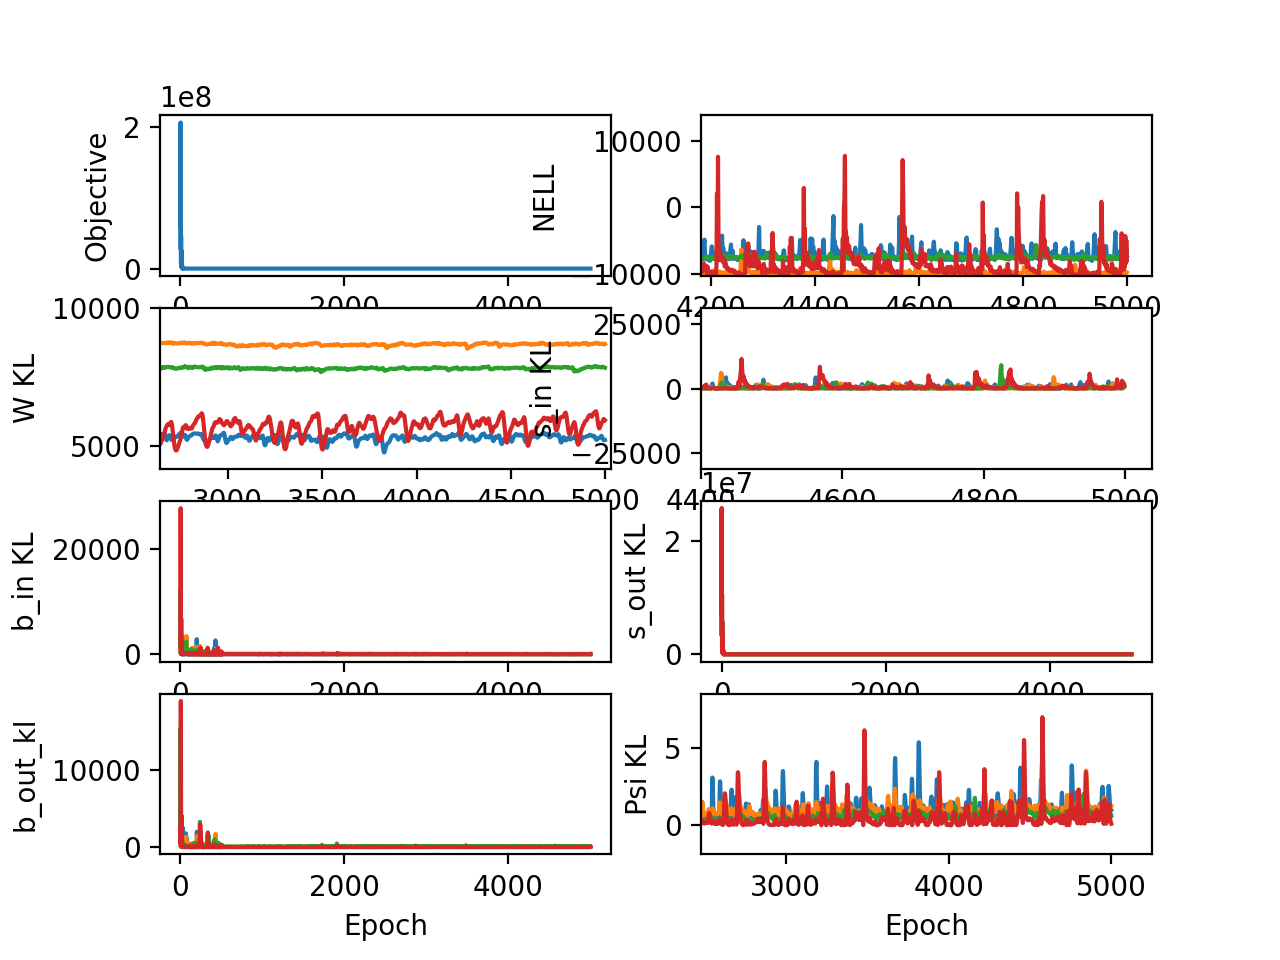

In [22]:
for log in exam_logs:
    Fitter.plot_log(log)

<IPython.core.display.Javascript object>


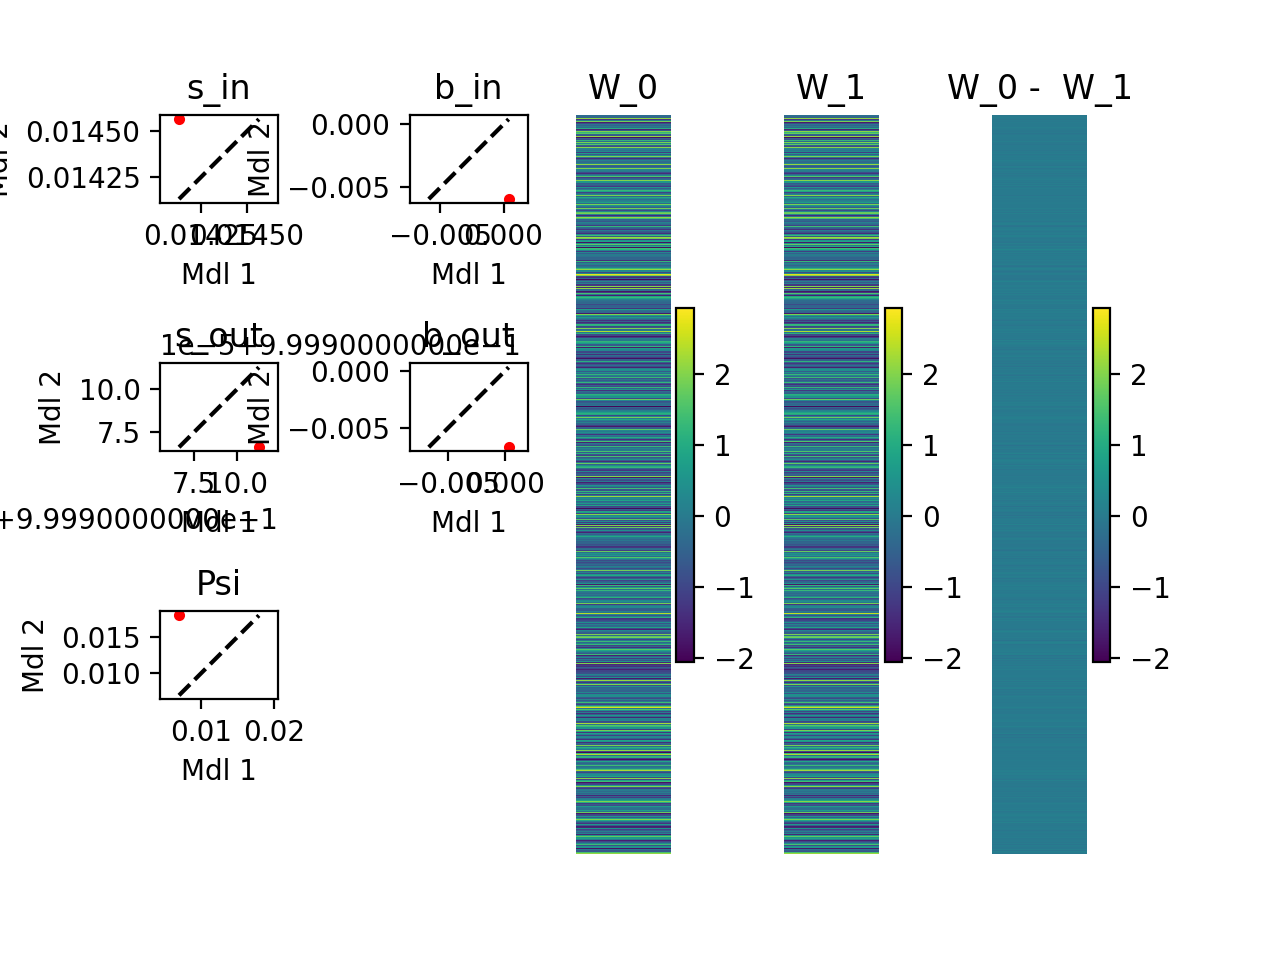

In [24]:
exam_w = exam_posts[exam_ind].w_post(ind_props[exam_ind])
exam_s_in = exam_posts[exam_ind].s_in_post(ind_props[exam_ind]).squeeze(axis=1)
exam_b_in = exam_posts[exam_ind].b_in_post(ind_props[exam_ind]).squeeze(axis=1)
exam_s_out = exam_posts[exam_ind].s_out_post(ind_props[exam_ind]).squeeze(axis=1)
exam_b_out = exam_posts[exam_ind].b_out_post(ind_props[exam_ind]).squeeze(axis=1)
exam_psi = exam_posts[exam_ind].psi_post.dists[0].mode(ind_props[exam_ind]).squeeze(axis=1)

exam_mdl = GNLRMdl(m = exam_vi_collections[exam_ind].mdl.m, w=exam_w, s_in=exam_s_in, b_in=exam_b_in, 
                  s_out=exam_s_out, b_out=exam_b_out, psi=exam_psi)

plt.figure()
GNLRMdl.compare_mdls(ind_true_mdls[exam_ind], exam_mdl)

## Look at predicted mean values over the full range of input values for the exam_ind individual

In [25]:
n_exam_smps = 1000

In [26]:
x_exam = torch.tensor(sample_proj_data_from_interval(n_smps=n_exam_smps, 
                                                      w=ind_true_mdls[exam_ind].w.detach().numpy(), 
                                                      interval=[intervals[0], intervals[-1]]),
                       dtype=torch.float)
#x_exam = ind_data[exam_ind][0]
#n_exam_smps = x_exam.shape[0]

In [27]:
with torch.no_grad():
    
    # Determine which of our test points are in and out of the training distribution for this individual 
    x_true_proj = ind_true_mdls[exam_ind].project(x_exam).numpy()
    x_true_proj_for_int = ind_true_mdls[exam_ind].project(x_exam, apply_scales_and_biases=False).numpy().squeeze()
    
    x_within_train_dist = np.logical_and(x_true_proj_for_int >= intervals[exam_ind], 
                                         x_true_proj_for_int < intervals[exam_ind+1])
    x_outside_train_dist = np.logical_not(x_within_train_dist)
    
    # Get true mean and predicted mean for each data point for this individual 
    true_mns = ind_true_mdls[exam_ind].m(ind_true_mdls[exam_ind].project(x_exam)).numpy()
    pred_mns = exam_mdls[exam_ind].cond_mean(x=x_exam, w=exam_w, s_in=exam_s_in, b_in=exam_b_in, 
                                             s_out=exam_s_out, b_out=exam_b_out)
    x_pred_proj = exam_mdls[exam_ind].project(x=x_exam, w=exam_w, s_in=exam_s_in, b_in=exam_b_in)


### Look at point-by-point correspondance

<IPython.core.display.Javascript object>


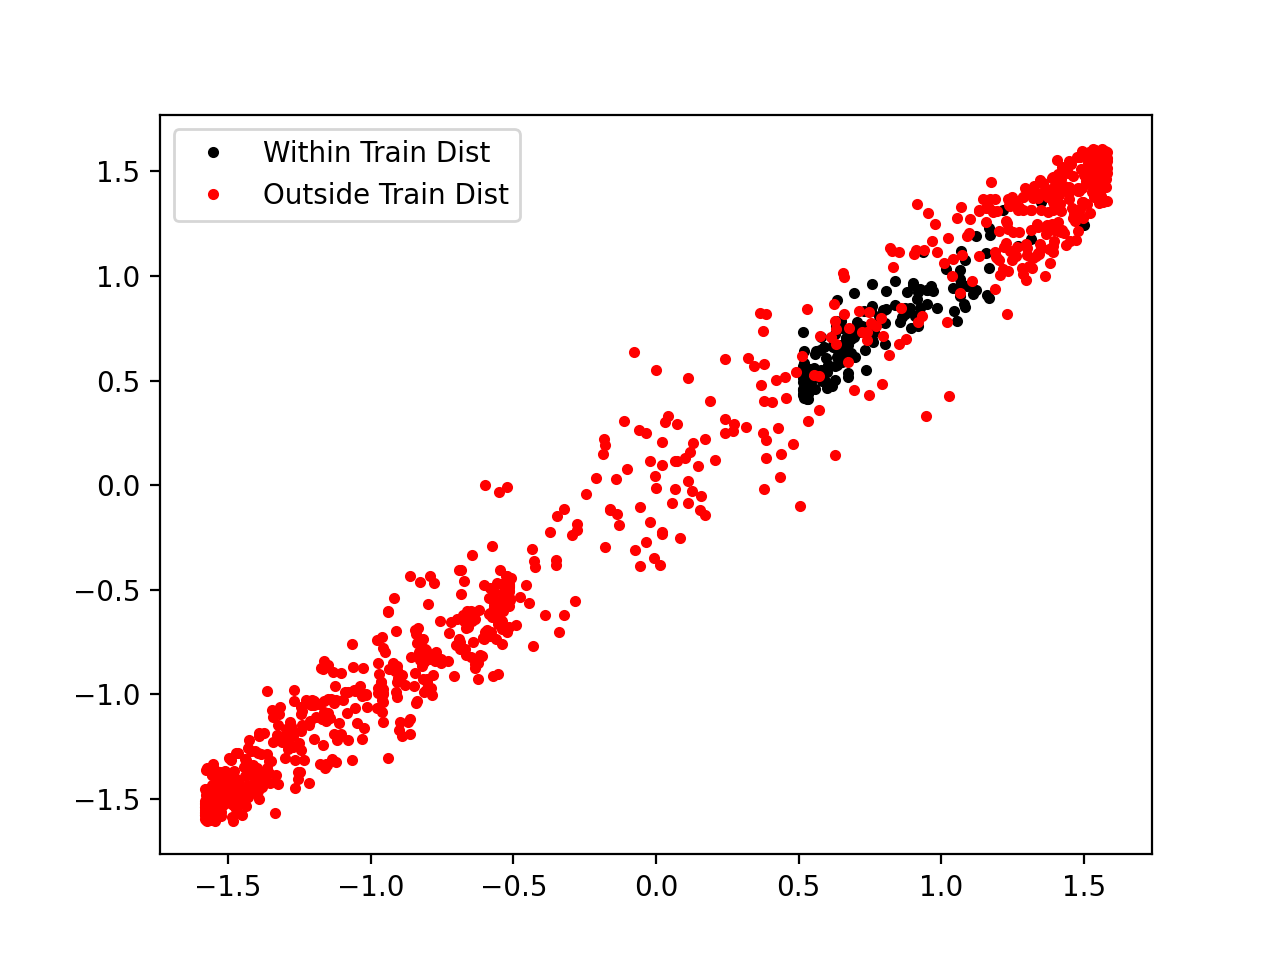

In [28]:
plt.figure()
plt.plot(true_mns[x_within_train_dist], pred_mns[x_within_train_dist], 'k.')
plt.plot(true_mns[x_outside_train_dist], pred_mns[x_outside_train_dist], 'r.')
plt.legend(['Within Train Dist', 'Outside Train Dist'])


## Look at correspondance of the m functions

### Look at shape of surface of true and predict means as a function of the true low-d projections

<IPython.core.display.Javascript object>


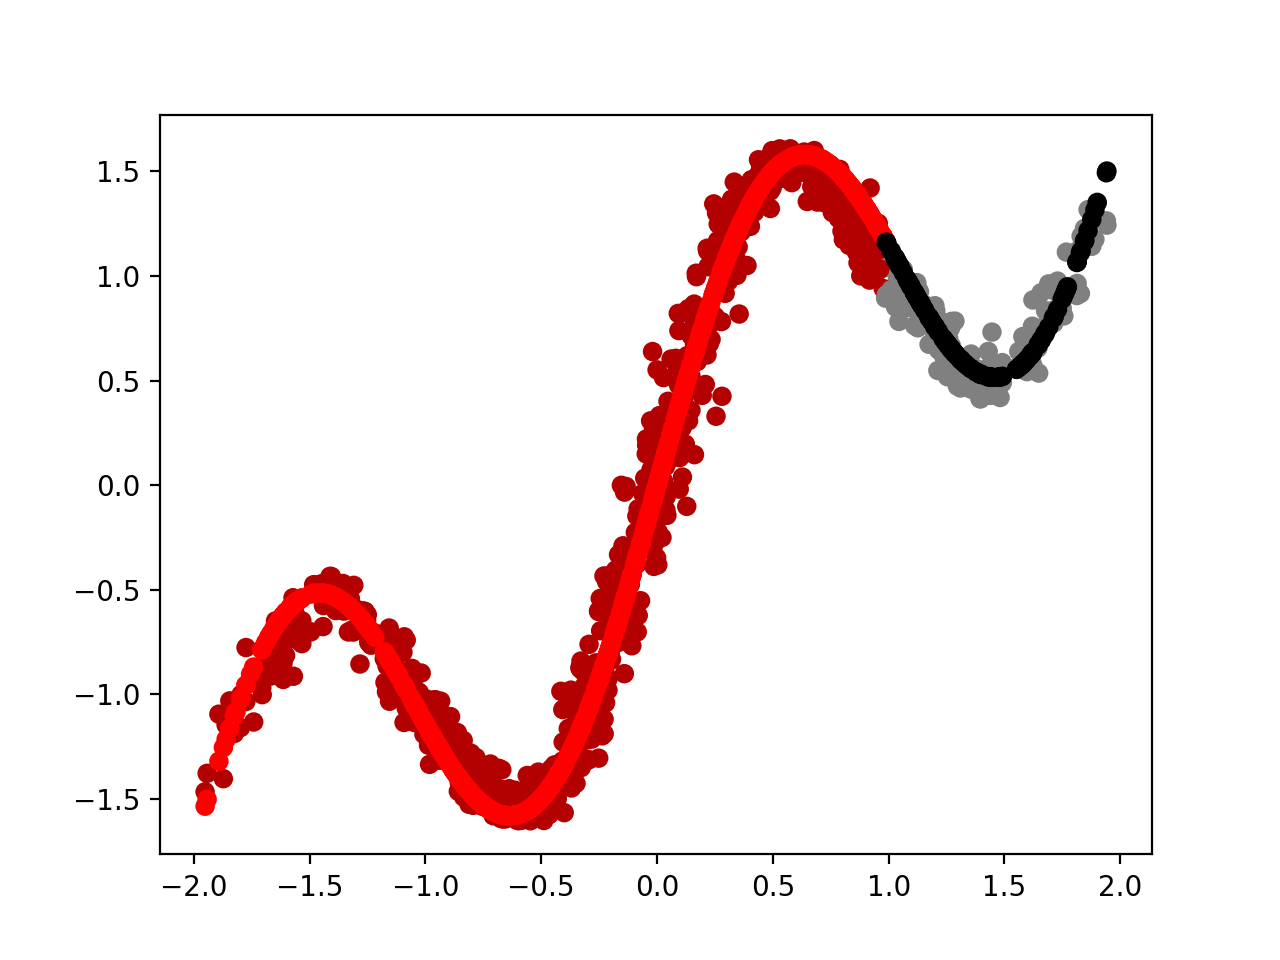

In [29]:
true_clrs = np.zeros([n_exam_smps,4])
true_clrs[:,-1] = 1.0
true_clrs[x_outside_train_dist, 0] = 1.0

pred_clrs = np.zeros([n_exam_smps,4])
pred_clrs[:, -1] = 1.0
pred_clrs[x_outside_train_dist, 0] = .7
pred_clrs[np.logical_not(x_outside_train_dist), 0:3] = .5


plt.figure()
a = plt.subplot(1,1,1)
a.scatter(x_true_proj, pred_mns, color=pred_clrs)
a.scatter(x_true_proj, true_mns, color=true_clrs)





### Look at shape of surface of true and predicted means when predicted means are also a function of the predicted low-d projections.

This is a more stringent test of identifiability than the above plots, becuase the learned models could "scramble" the projection to the low-s space and then the learned m-module could sort it out so that mean predictions when viewed as a function from input variables to means is correct, even though the intermediate transformation to low-d variables, and therefore the mapping from low-d variables to means, is not the same as the true models

In [30]:
# Get the estimate low-d projections in the space best aligned to truth

align_vls = align_low_d_spaces(w_0=ind_true_mdls[exam_ind].w.detach().numpy(),
                               s_in_0=ind_true_mdls[exam_ind].s_in.detach().numpy(),
                               b_in_0=ind_true_mdls[exam_ind].b_in.detach().numpy(),
                               w_1=exam_w.detach().numpy(),
                               s_in_1=exam_s_in.detach().numpy(),
                               b_in_1=exam_b_in.detach().numpy(),
                               z_1=x_pred_proj.numpy())

x_pred_proj_aligned = align_vls[-1]

<IPython.core.display.Javascript object>


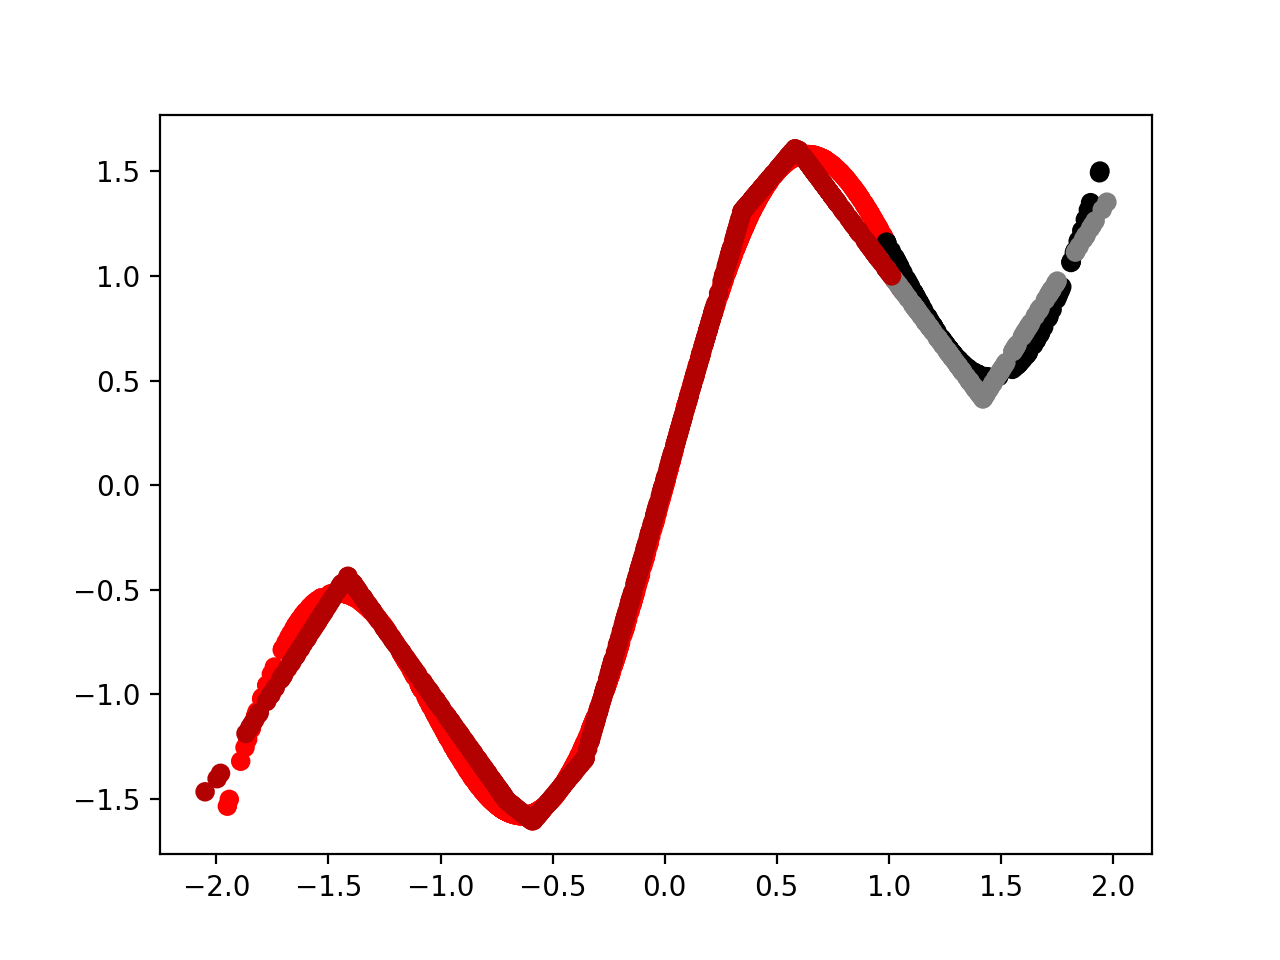

In [31]:
# Generate plots
plt.figure()
a = plt.subplot(1,1,1)
a.scatter(x_true_proj, true_mns, color=true_clrs)
a.scatter(x_pred_proj_aligned, pred_mns, color=pred_clrs)


## Compare true and fit prior distributions over weights

<IPython.core.display.Javascript object>


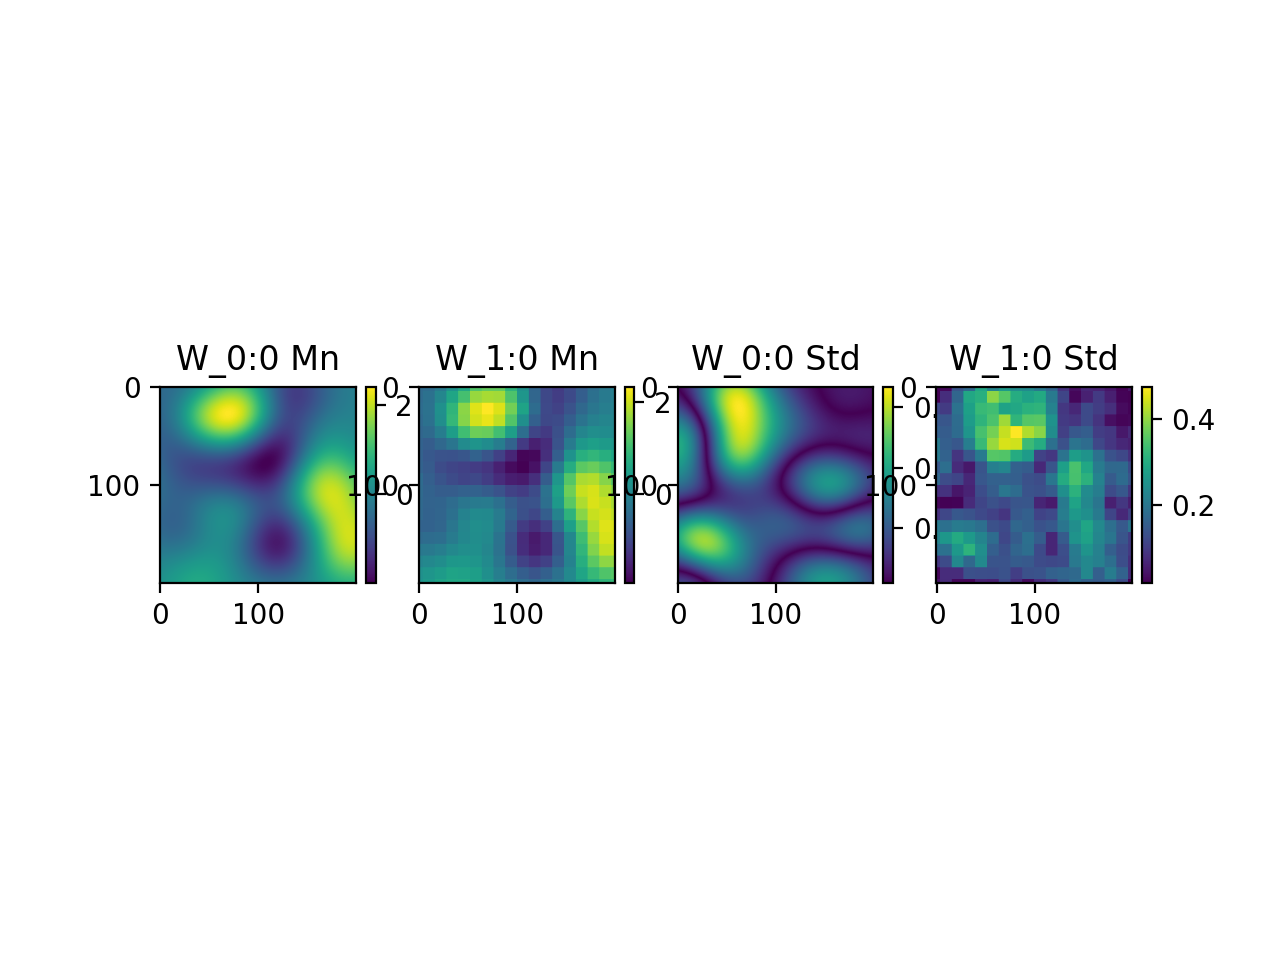

In [32]:
compare_weight_prior_dists(w0_prior=true_priors.w_prior, w1_prior=exam_priors.w_prior, 
                           dim_0_range=[0, 1], dim_1_range=[0, 1], n_pts_per_dim=[200, 200])

In [33]:
## Debug code

In [34]:
def f(x): 
    return x + np.sin(3*x) 

In [35]:
x_vls = np.linspace(-2, 2, 100)
y_vls = f(x_vls)

<IPython.core.display.Javascript object>


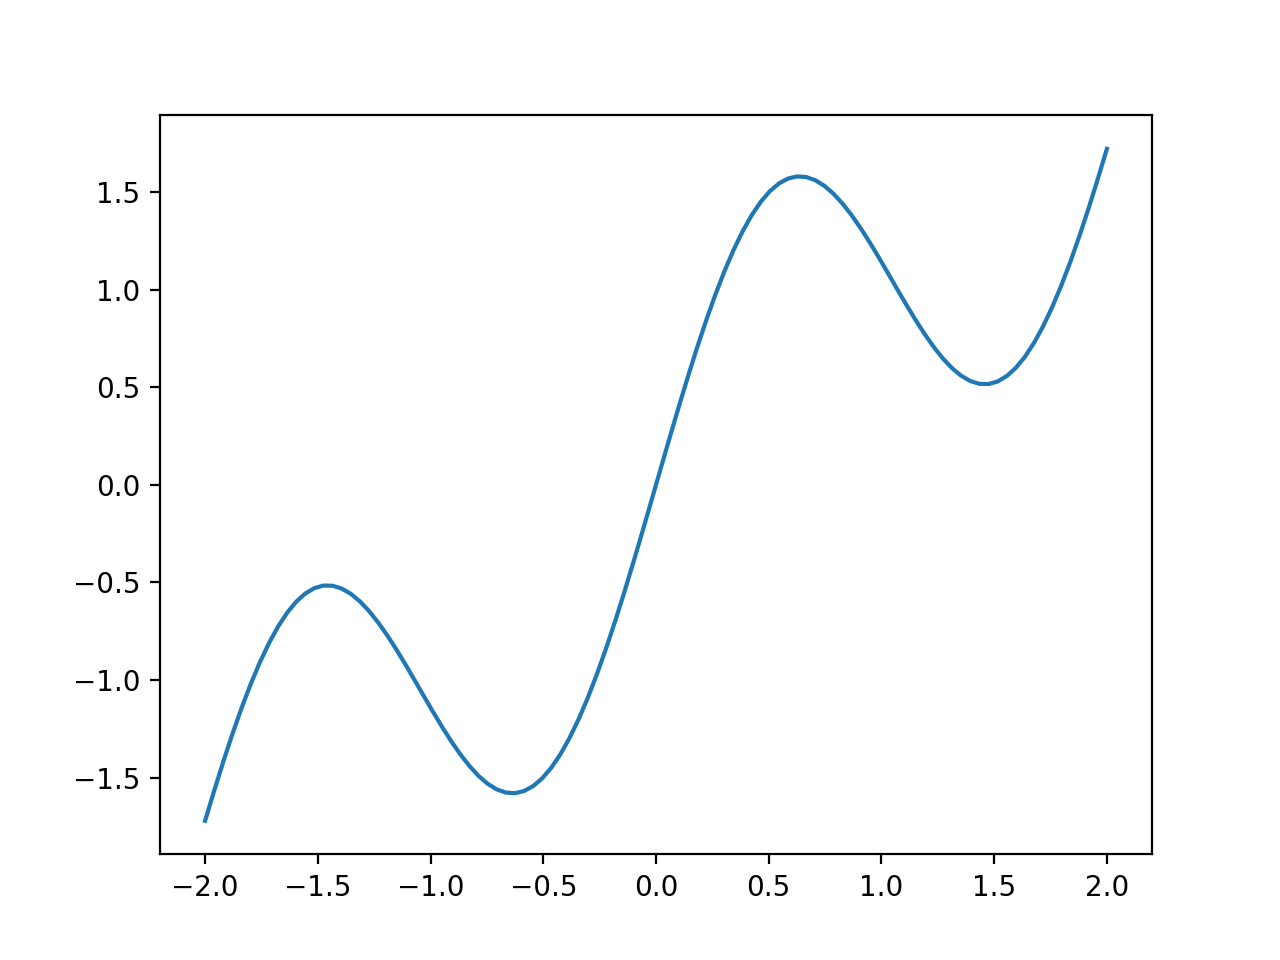

In [36]:
plt.figure()
plt.plot(x_vls, y_vls)

In [37]:
exam_posts[0].psi_post.dists[0].conc_f(ind_props[0])

tensor([[441.5406]], grad_fn=<TBackward>)

In [38]:
exam_posts[0].psi_post.dists[0].rate_f(ind_props[0])

tensor([[22838.5059]], grad_fn=<TBackward>)

In [39]:
fit_m = exam_mdl.m

In [40]:
fit_m[0].dense_lnl_2.m[0].bias

Parameter containing:
tensor([-1.0433, -0.6911, -0.5480, -0.6331, -0.2521], requires_grad=True)

In [41]:
fit_m[0].dense_lnl_0.m[0].weight

Parameter containing:
tensor([[ 0.3018],
        [ 0.8887],
        [-0.3675],
        [ 0.4421],
        [-0.0316]], requires_grad=True)

In [ ]:
fit_m[0].dense_lnl_2